In [2]:
import pandas as pd
import numpy as np
import functools
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split

# Define the diffusion model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def index_iterator(device, data_len, batchsize = 32):
    perm_idx = np.random.permutation(data_len)
    num_steps = (data_len // batchsize) if (data_len % batchsize) == 0 else (data_len // batchsize) + 1
    for ii in range(num_steps):
        if ii < (num_steps - 1):
            batch_idx = perm_idx[(ii*batchsize):(ii*batchsize+batchsize)]
        else:
            batch_idx = perm_idx[(ii*batchsize):]
        
        yield batch_idx

class Diffusion_SDE(nn.Module):
    def __init__(self, input_dim, cond_dim, time_emb_dim = 32, eps=1e-5, sigma = 100, scale = 9,block_layer =1, device=None):
        super(Diffusion_SDE, self).__init__()
        self.device = device
        self.marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
        self.diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)
        self.eps = eps
        self.score_model = UNet_MLP(input_dim, cond_dim, self.marginal_prob_std_fn, time_emb_dim = time_emb_dim, scale = scale, block_layer = block_layer).to(device)
        self.input_dim = input_dim
    
    def forward(self, x0, cond):
        # 前向加噪声的过程
        random_t = torch.rand(x0.shape[0], device=self.device) * (1. - self.eps) + self.eps 
        z = torch.randn_like(x0)
        std = self.marginal_prob_std_fn(random_t)
        perturbed_x = x0 + z * std[:, None]
        # U-Net模型
        score = self.score_model(perturbed_x, cond, random_t) * std[:, None]
        loss = torch.mean(torch.sum((score  + z)**2, dim=1))
        
        return loss
    
    def em_sampler(self, cond, num_steps=1000,eps=1e-3):
        sample_size = cond.shape[0]
        t = torch.ones(sample_size, device=self.device)
        init_x = torch.randn((sample_size, self.input_dim), device=self.device) \
        * self.marginal_prob_std_fn(t)[:, None]
        time_steps = torch.linspace(1., eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]
        x = init_x

        with torch.no_grad():
            for time_step in time_steps:      
                batch_time_step = torch.ones(sample_size, device=device) * time_step
                g = self.diffusion_coeff_fn(batch_time_step)
                mean_x = x + (g**2)[:, None] * (self.score_model(x, cond, batch_time_step)) * step_size

                x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        return mean_x
            
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out


def marginal_prob_std(t, sigma):
    #t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return sigma**t
  

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, marginal_prob_std, time_emb_dim=32, scale = 4, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))

        
        self.marginal_prob_std = marginal_prob_std
        
        self.input_dim = input_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_dim, second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, xc, ti):
        
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)

        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out / self.marginal_prob_std(ti)[:, None]

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

  6%|▌         | 6/100 [11:26:23<179:13:27, 6863.91s/it]


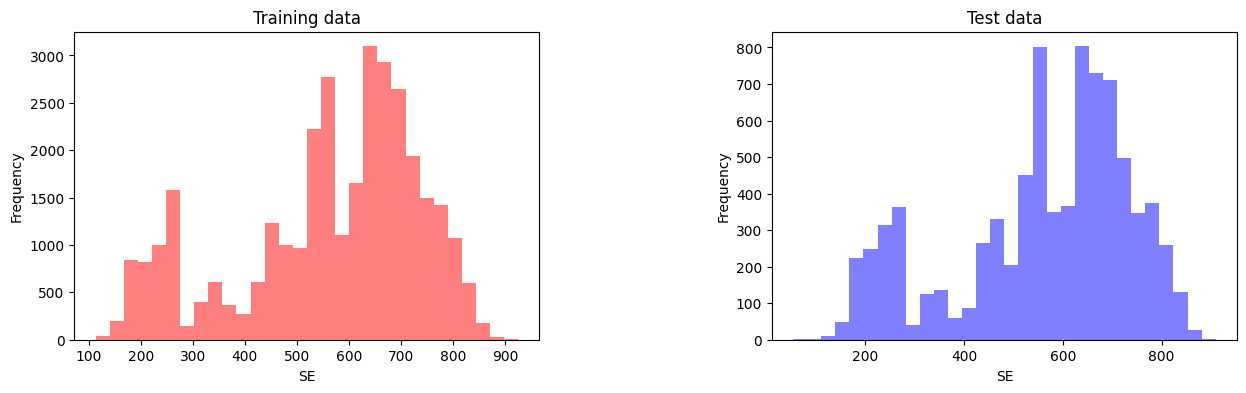

In [28]:
CSI_RSRP_COLUMNS = ['PCell1 -Beam CSI-RSRP','PCell2 -Beam CSI-RSRP','PCell3 -Beam CSI-RSRP',
                    'PCell4 -Beam CSI-RSRP','PCell5 -Beam CSI-RSRP','PCell6 -Beam CSI-RSRP','PCell7 -Beam CSI-RSRP','PCell8 -Beam CSI-RSRP']
CSI_RSRQ_COLUMNS = ['PCell1 -Beam CSI-RSRQ','PCell2 -Beam CSI-RSRQ','PCell3 -Beam CSI-RSRQ',
                    'PCell4 -Beam CSI-RSRQ','PCell5 -Beam CSI-RSRQ','PCell6 -Beam CSI-RSRQ','PCell7 -Beam CSI-RSRQ','PCell8 -Beam CSI-RSRQ']
CSI_SINR_COLUMNS = ['PCell1 -Beam CSI-SINR','PCell2 -Beam CSI-SINR','PCell3 -Beam CSI-SINR',
                    'PCell4 -Beam CSI-SINR','PCell5 -Beam CSI-SINR','PCell6 -Beam CSI-SINR','PCell7 -Beam CSI-SINR','PCell8 -Beam CSI-SINR']
CSI_INDEX_COLUMNS = ['PCell1 -Beam CSI-Index','PCell2 -Beam CSI-Index','PCell3 -Beam CSI-Index',
                    'PCell4 -Beam CSI-Index','PCell5 -Beam CSI-Index','PCell6 -Beam CSI-Index','PCell7 -Beam CSI-Index','PCell8 -Beam CSI-Index']
SS_SINR_COLUMNS = ['SSB Index0 SINR','SSB Index1 SINR','SSB Index2 SINR','SSB Index3 SINR','SSB Index4 SINR','SSB Index5 SINR','SSB Index6 SINR']
SS_RSRP_COLUMNS = ['SSB Index0 RSRP','SSB Index1 RSRP','SSB Index2 RSRP','SSB Index3 RSRP','SSB Index4 RSRP','SSB Index5 RSRP','SSB Index6 RSRP']
CSI_SERVING_COL = ['PCell1 -Beam Serving Beam','PCell2 -Beam Serving Beam','PCell3 -Beam Serving Beam','PCell4 -Beam Serving Beam','PCell5 -Beam Serving Beam',
                   'PCell6 -Beam Serving Beam','PCell7 -Beam Serving Beam','PCell8 -Beam Serving Beam']
CSI_RSRP_IDX_COLUNMS = ['CSI-RSRP-Index0', 'CSI-RSRP-Index1', 'CSI-RSRP-Index2', 'CSI-RSRP-Index3', 'CSI-RSRP-Index4', 'CSI-RSRP-Index5','CSI-RSRP-Index6', 'CSI-RSRP-Index7',
                        'CSI-RSRP-Index8', 'CSI-RSRP-Index9', 'CSI-RSRP-Index10', 'CSI-RSRP-Index11', 'CSI-RSRP-Index12','CSI-RSRP-Index13', 'CSI-RSRP-Index14', 'CSI-RSRP-Index15',
                        'CSI-RSRP-Index16', 'CSI-RSRP-Index17', 'CSI-RSRP-Index18', 'CSI-RSRP-Index19','CSI-RSRP-Index20', 'CSI-RSRP-Index21', 'CSI-RSRP-Index22', 'CSI-RSRP-Index23',
                        'CSI-RSRP-Index24', 'CSI-RSRP-Index25', 'CSI-RSRP-Index26', 'CSI-RSRP-Index27', 'CSI-RSRP-Index28', 'CSI-RSRP-Index29', 'CSI-RSRP-Index30', 'CSI-RSRP-Index31']
CSI_SINR_IDX_COLUNMS = ['CSI-SINR-Index0', 'CSI-SINR-Index1', 'CSI-SINR-Index2', 'CSI-SINR-Index3', 'CSI-SINR-Index4', 'CSI-SINR-Index5','CSI-SINR-Index6', 'CSI-SINR-Index7',
                        'CSI-SINR-Index8', 'CSI-SINR-Index9', 'CSI-SINR-Index10', 'CSI-SINR-Index11', 'CSI-SINR-Index12','CSI-SINR-Index13', 'CSI-SINR-Index14', 'CSI-SINR-Index15',
                        'CSI-SINR-Index16', 'CSI-SINR-Index17', 'CSI-SINR-Index18', 'CSI-SINR-Index19','CSI-SINR-Index20', 'CSI-SINR-Index21', 'CSI-SINR-Index22', 'CSI-SINR-Index23',
                        'CSI-SINR-Index24', 'CSI-SINR-Index25', 'CSI-SINR-Index26', 'CSI-SINR-Index27', 'CSI-SINR-Index28', 'CSI-SINR-Index29', 'CSI-SINR-Index30', 'CSI-SINR-Index31']
PERFORMANCE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s','NR PRB Num DL/slot','NR RI','NR Avg Rank DL/s',
                       'NR DL Total NACK/s','NR DL Total ACK/s','NR PDSCH Initial BLER','NR PDSCH BLER','NR DL Avg MCS'] 
ALL_COLUMNS = CSI_RSRP_COLUMNS+CSI_RSRQ_COLUMNS+CSI_SINR_COLUMNS+CSI_INDEX_COLUMNS+SS_SINR_COLUMNS+SS_RSRP_COLUMNS+PERFORMANCE_COLUMNS
# 归一化参数
RSRP_MAX = -40
RSRP_MIN = -125
RSRQ_MAX = -4
RSRQ_MIN = -30
SE_MAX = 4000
RI_MAX = 4
MCS_MAX = 27
SINR_MAX = 50
SINR_MIN = -20
RI_COLUMN = ['NR Avg Rank DL/s']
MCS_COLUMN = ['NR DL Avg MCS']
BLER_COLUMN = ['NR PDSCH BLER']
SEVING_IDX = ['Serving idx']

SE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s']
train_features = CSI_RSRP_IDX_COLUNMS+SEVING_IDX+SS_RSRP_COLUMNS
# with open('dt_cuhk/0410/data_set/data_interp1d.pkl','rb') as f:
# with open('dt_cuhk/0411/data_set/data_interp1d_linear.pkl','rb') as f:
with open('dt_cuhk/0412/data_set/data_900_linear_by_idx.pkl','rb') as f:
# with open('dt_cuhk/0412/data_set/data_900_linear.pkl','rb') as f:
    data_set_901_412 = pickle.load(f)
# with open('dt_cuhk/0412/data_set/data_901_linear.pkl','rb') as f:
with open('dt_cuhk/0415/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_415 = pickle.load(f)
with open('dt_cuhk/0412/data_set/data_900_linear_by_idx.pkl','rb') as f:
    data_set_900_412 = pickle.load(f)
with open('dt_cuhk/0418/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_418 = pickle.load(f)
with open('dt_cuhk/0420/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_420 = pickle.load(f)
with open('dt_cuhk/0426/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_426 = pickle.load(f)
data_set_834 = pd.concat((data_set_834_415,data_set_834_418,data_set_834_420,data_set_834_426))

train,test = train_test_split(data_set_834,test_size=0.2,random_state=1)
# train = data_set_900_412
# val = data_set_834_418
# test = data_set_901_412
train_x = train[train_features]
train_y = train['SE']

test_x = test[train_features]
test_y = test['SE']

# val_x = val[train_features]
# val_y = val['SE']


# 创建三个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一个子图
axs[0].hist(train['NR MAC Throughput DL'], bins=30, alpha=0.5, color='r')
axs[0].set_xlabel('SE')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training data')


# 绘制第二个子图
axs[1].hist(test['NR MAC Throughput DL'], bins=30, alpha=0.5, color='b')
axs[1].set_xlabel('SE')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test data')

# 调整子图之间的距离
plt.subplots_adjust(wspace=0.5)

# 显示图像
plt.show()


train_x = train_x[train_features].to_numpy()
test_x = test_x[train_features].to_numpy()
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()


cond_dim = len(train_features)
X_tensor = torch.FloatTensor(train_y).reshape(-1,1)
r_tensor = torch.FloatTensor(train_x[:,:cond_dim])

# train the diffusion score model

In [30]:
# diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)
diffusion_process = Diffusion_SDE(input_dim = 1, cond_dim=cond_dim, scale = 9,block_layer=2, sigma = 100, device=device)

In [31]:
# training 
batchsize = 128
epoch = 2000
lr = 8e-4
optimizer = Adam(diffusion_process.parameters(), lr)

# initialize best loss and corresponding model state dict
best_loss = float('inf')
best_model_state_dict = None
patience = 100 # 超过patience个epoch没有loss下降就停止训练
no_improvement_count = 0 # 记录连续没有改善的epoch数
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(X_tensor), batchsize = 128):
        optimizer.zero_grad()
        steps +=1 
        x0 = X_tensor[batch_index].cuda()
        xc = r_tensor[batch_index].cuda()
        loss = diffusion_process(x0, xc)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    # check if current loss is better than best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state_dict = diffusion_process.state_dict()
    if ep % 100 == 0:     
        torch.save(diffusion_process.state_dict(), "model.pkl")
        print("save model")
     # early stopping
    if avg_loss/(steps+1) < best_loss:
        best_loss = avg_loss/(steps+1)
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    if no_improvement_count >= patience:
        print("Early stopping at epoch", ep)
        break
        
# save the best model to file
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "best_model.pkl")
    print("save best model with loss: ", best_loss)

  0%|          | 1/2000 [00:08<4:45:21,  8.56s/it, avg_loss=0.199]

save model


  5%|▌         | 101/2000 [13:27<4:10:49,  7.92s/it, avg_loss=0.0133]

save model


 10%|█         | 201/2000 [26:44<4:00:32,  8.02s/it, avg_loss=0.0106]

save model


 15%|█▌        | 301/2000 [40:17<3:51:07,  8.16s/it, avg_loss=0.00937]

save model


 20%|██        | 401/2000 [53:43<3:34:37,  8.05s/it, avg_loss=0.00872]

save model


 20%|██        | 407/2000 [54:32<3:37:09,  8.18s/it, avg_loss=0.00869]

# train the mlp

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=17, output_dim=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self,x):
        return self.layers(x)
    
mlp = MLP(cond_dim,1).cuda()

In [ ]:

    
# training 
batchsize = 32
epoch = 1000
lr = 1e-3
optimizer = Adam(mlp.parameters(), lr)
loss_func = torch.nn.MSELoss()

# initialize best loss and corresponding model state dict
best_loss = float('inf')
best_model_state_dict = None
patience = 10 # 超过patience个epoch没有loss下降就停止训练
no_improvement_count = 0 # 记录连续没有改善的epoch数
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(X_tensor), batchsize = 64):
        optimizer.zero_grad()
        steps +=1 
        x0 = X_tensor[batch_index].cuda()
        xc = r_tensor[batch_index].cuda()
        loss = loss_func(mlp(xc),x0)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    # check if current loss is better than best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state_dict = mlp.state_dict()
    if ep % 100 == 0:     
        torch.save(mlp.state_dict(), "model_mlp.pkl")
        print("save model")
     # early stopping
    if avg_loss/(steps+1) < best_loss:
        best_loss = avg_loss/(steps+1)
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    if no_improvement_count >= patience:
        print("Early stopping at epoch", ep)
        break
        
# save the best model to file
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "best_model_mlp.pkl")
    print("save best model with loss: ", best_loss)

# draw sample from diffusion for val data

In [ ]:
test_tensor = torch.FloatTensor(test_x[:,:cond_dim]).to(device)
test_y_tensor = torch.FloatTensor(test_y)

In [24]:
diffusion_process.load_state_dict(torch.load("best_model.pkl"))
sample_size = 100 # the number of sample to draw from diffusion for each input
sampled_y = torch.cat([diffusion_process.em_sampler(test_tensor).cpu() for _ in tqdm(range(sample_size))],axis=1)


























































































































































100%|██████████| 100/100 [32:11<00:00, 19.32s/it]


# deterministic prediction given by mlp

In [ ]:
mlp.load_state_dict(torch.load("best_model_mlp.pkl"))
with torch.no_grad():
    mlp_est_y = mlp(test_tensor).cpu().flatten()

# compare mlp and diffusion

In [25]:
for i in range(sample_size):
    print("diffusion error for sample {}:".format(i), np.mean((sampled_y[:,i].numpy()-test_y)**2), np.max((sampled_y[:,i].numpy()-test_y)**2))
print("mlp:", np.mean((mlp_est_y.numpy()-test_y)**2), np.max((mlp_est_y.numpy()-test_y)**2))

diffusion error for sample 0: 0.0016632372371391693 0.03676103206058038
diffusion error for sample 1: 0.0017816399798958277 0.03439338864400956
diffusion error for sample 2: 0.0016896459101440283 0.033453274871307184
diffusion error for sample 3: 0.0016481785346749306 0.0412534840910646
diffusion error for sample 4: 0.001735322782754626 0.09757534513824007
diffusion error for sample 5: 0.0016717938289475978 0.033131339070963446
diffusion error for sample 6: 0.0016954517754648592 0.028250825419157143
diffusion error for sample 7: 0.001708836917046955 0.03120439174290371
diffusion error for sample 8: 0.0017011514121684874 0.0736361668812594
diffusion error for sample 9: 0.001654246340074957 0.039710545069163015
diffusion error for sample 10: 0.0017162310179422969 0.031120400185896353
diffusion error for sample 11: 0.0017036641193909504 0.05261564844834898
diffusion error for sample 12: 0.0016728667968402946 0.02719260132490362
diffusion error for sample 13: 0.0016745288013784625 0.040876

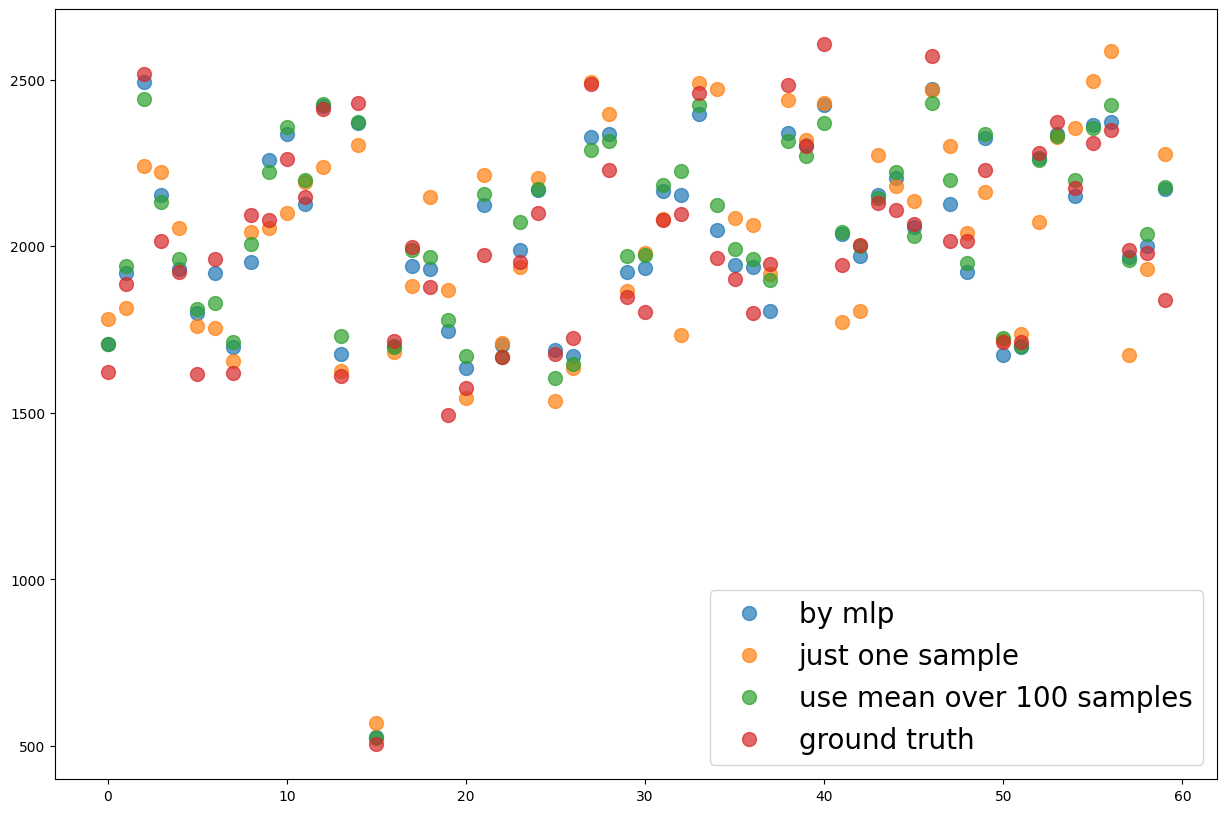

one diffusion sample: 0.0016632372371391693 0.03676103206058038
diffusion mean over 100 samples: 0.0006903921219613663 0.03220506995917036
mlp: 0.0005849518717970106 0.01624702059247978


In [26]:
sample_y_mean = sampled_y.mean(axis=1)

plt.figure(figsize=(15,10))
plt.plot(mlp_est_y[:60]*SE_MAX,".",alpha=0.7,markersize=20,label="by mlp")
plt.plot(sampled_y[:60,0]*SE_MAX,".",alpha=0.7,markersize=20,label="just one sample")
plt.plot(sample_y_mean[:60]*SE_MAX,".",alpha=0.7,markersize=20,label="use mean over 100 samples")
plt.plot(test_y[:60]*SE_MAX,".",alpha=0.7,markersize=20,label="ground truth")
plt.legend(prop={"size":20})
plt.show()

print("one diffusion sample:", np.mean((sampled_y.numpy()[:,0]-test_y)**2),np.max((sampled_y.numpy()[:,0]-test_y)**2)) # mean error, max error
print("diffusion mean over 100 samples:", np.mean((sample_y_mean.numpy()-test_y)**2), np.max((sample_y_mean.numpy()-test_y)**2))
print("mlp:", np.mean((mlp_est_y.numpy()-test_y)**2), np.max((mlp_est_y.numpy()-test_y)**2))

# plot 99% confidence interval

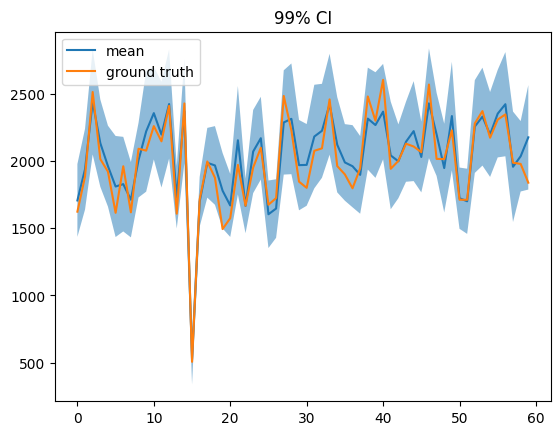

coverage of 90% CI 94.92109559223654
coverage of 95% CI 97.3879920188645
coverage of 99% CI 99.25630328314892
coverage of min-max interval 99.383275893343


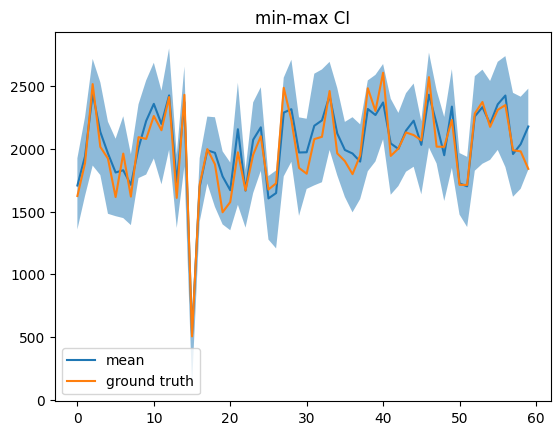

In [27]:
sample_y_std = sampled_y.std(axis=1)

CI90 = 1.645
CI95 = 1.96
CI99 = 2.576

plt.plot(sample_y_mean[:60]*SE_MAX,label="mean")
plt.fill_between(np.arange(60),(sample_y_mean[:60]-CI99*sample_y_std[:60])*SE_MAX,(sample_y_mean[:60]+CI99*sample_y_std[:60])*SE_MAX,alpha=0.5)
plt.plot(test_y[:60]*SE_MAX,label="ground truth")
plt.legend()
plt.title("99% CI")
plt.show()

print("coverage of 90% CI", np.mean((test_y>=(sample_y_mean-CI90*sample_y_std).numpy()) & (test_y<=(sample_y_mean+CI90*sample_y_std).numpy())) * 100)
print("coverage of 95% CI", np.mean((test_y>=(sample_y_mean-CI95*sample_y_std).numpy()) & (test_y<=(sample_y_mean+CI95*sample_y_std).numpy())) * 100)
print("coverage of 99% CI", np.mean((test_y>=(sample_y_mean-CI99*sample_y_std).numpy()) & (test_y<=(sample_y_mean+CI99*sample_y_std).numpy())) * 100)
print("coverage of min-max interval", np.mean((test_y>=sampled_y.min(axis=1).values.numpy()) & (test_y<=sampled_y.max(axis=1).values.numpy())) * 100)

plt.plot(sample_y_mean[:60]*SE_MAX,label="mean")
plt.fill_between(np.arange(60),(sampled_y.min(axis=1).values.numpy()[:60])*SE_MAX,(sampled_y.max(axis=1).values.numpy()[:60])*SE_MAX,alpha=0.5)
plt.plot(test_y[:60]*SE_MAX,label="ground truth")
plt.legend()
plt.title("min-max CI")
plt.show()